In [2]:
import numpy as np
import pandas as pd
from threading import Thread
import time
import matplotlib.pyplot as plt
import json
import os
from bs4 import BeautifulSoup
import torch
# from torch import nn
# from torch.utils.data import DataLoader, Dataset
# from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

import seaborn as sns
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.svm import SVC
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#nltk.download('stopwords')

Data Cleaning and Preparation

In [4]:
# Load the csv file containing style data
styles_df = pd.read_csv('styles.csv', on_bad_lines='skip')

In [5]:
# Display the dimensions
print(styles_df.shape)
# View data
styles_df.head()

(44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
# View data types
styles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

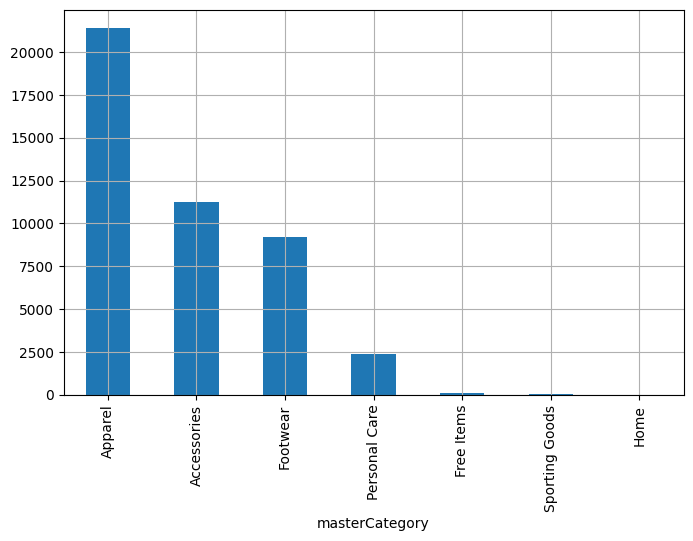

In [7]:
# Find out how much of each category there is originally
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [8]:
# Check the frequency of null values in each column
styles_df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [9]:
# Check how many null values per row
styles_df.isnull().sum(axis=1).sort_values(ascending = False)

17639    3
14291    3
23484    3
37531    3
40675    3
        ..
44419    0
44420    0
44421    0
44422    0
44407    0
Length: 44424, dtype: int64

In [10]:
#delete rows with missing variables
styles_df = styles_df.dropna()

(44077, 10)
masterCategory
Apparel           21366
Accessories       11244
Footwear           9197
Personal Care      2139
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

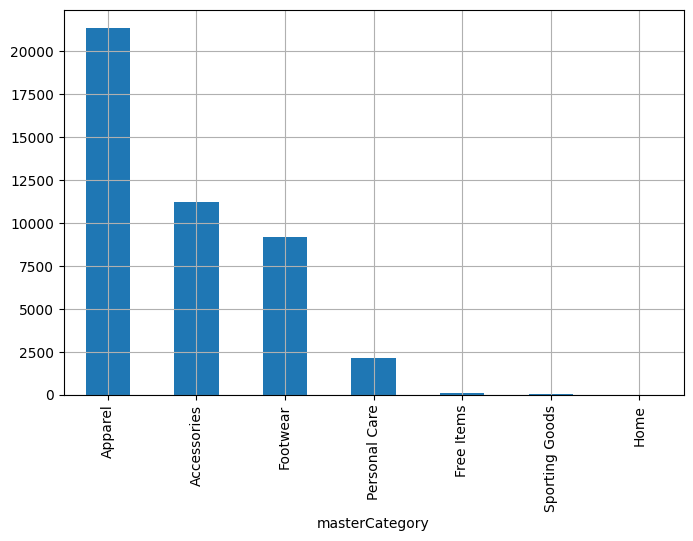

In [11]:
# Display the dimensions
print(styles_df.shape)
# Find out how much of each category there is after removing things with 3 or more missing variables
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [12]:
# Limit the data to 2016 onward to keep the data more current
styles_df = styles_df[(styles_df['year'] >= 2016)]
# Reset the indices once rows are removed
styles_df.reset_index(drop=True, inplace=True)

masterCategory
Accessories      4611
Personal Care    2139
Apparel          1767
Footwear          504
Free Items         63
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

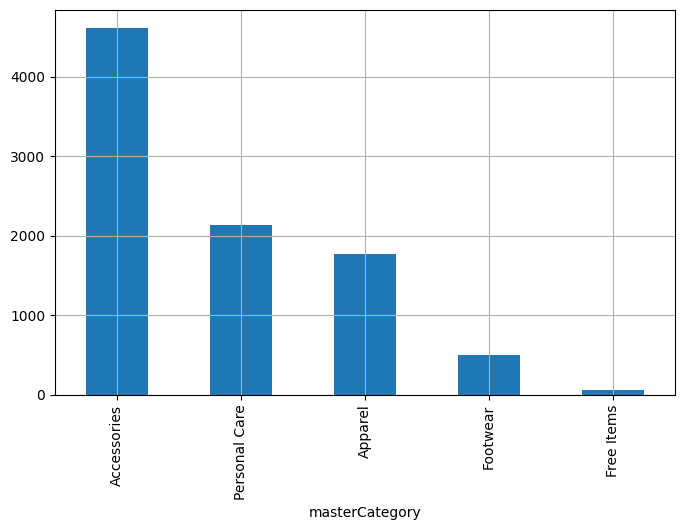

In [13]:
# Find out how much of each category there is after only looking beyond 2016
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [14]:
# Remove 2500 random samples (undersampling) to even things out
only_accessories = styles_df[styles_df['masterCategory'] == 'Accessories']
random_accessories = only_accessories.sample(2500)
styles_df = styles_df.drop(random_accessories.index)

masterCategory
Personal Care    2139
Accessories      2111
Apparel          1767
Footwear          504
Free Items         63
Name: count, dtype: int64


<Axes: xlabel='masterCategory'>

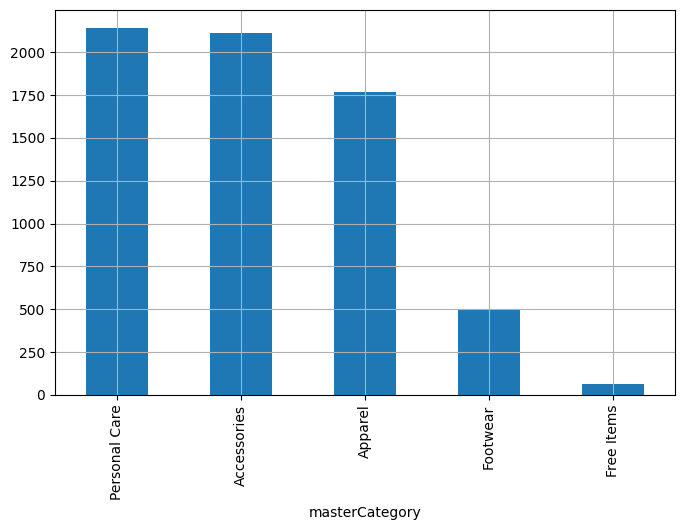

In [15]:
# Check the bar plots now that they have been evened out
counts = styles_df['masterCategory'].value_counts()
print(counts)
counts.plot(kind='bar', legend=False, grid=True, figsize=(8, 5))

In [16]:
# Create a new column 'category_id' with encoded categories 
styles_df['category_id'] = styles_df['masterCategory'].factorize()[0]
category_id_df = styles_df[['masterCategory', 'category_id']].drop_duplicates()

category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'masterCategory']].values)

styles_df = styles_df[styles_df['masterCategory'] != 'Home']

# New dataframe
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0
1,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,0
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2


In [17]:
# Display the dimensions
print(styles_df.shape)
# View data
styles_df.head()

(6584, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0
1,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,0
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2


In [18]:
descriptions = []

#Loop through the ids in the column and get the Json file corresponding to each one
for id_value in styles_df['id']:
    json_file = os.path.join('styles', f"{id_value}.json")

    try:
        with open(json_file, 'r', encoding='utf-8') as file:
            data = json.load(file)
            #Find the value within the JSON structure
            description = data['data']['productDescriptors']['description']['value']
            description = BeautifulSoup(description, 'lxml').text
    except:
            description = None

    descriptions.append(description)

# Create a new column in the dataframe with the descriptions from the Json file
styles_df["description"] = descriptions

In [19]:
#pd.set_option('max_colwidth', None)
# Display the dimensions
print(styles_df.shape)
#Display the new column
print(styles_df['description'])
# View data
styles_df.head(15)

(6584, 12)
0       Silver steel case with a fixed bezel for durab...
1       The skagen Denmark Collection reflects creativ...
3       Beige knitted non-wired and non-padded full-co...
5       Smooth and sophisticated, the Beckham Signatur...
6       With Vitamin A and E and apricot oil, the Soft...
                              ...                        
9078                                                    -
9079    The final product delivered might vary in colo...
9081    Baked on Italian terracotta tilesEnriched with...
9082    Style Note rasasi impresses and flatters your ...
9083    Case style: Analogue watch, has a circular cas...
Name: description, Length: 6584, dtype: object


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,category_id,description
0,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,0,Silver steel case with a fixed bezel for durab...
1,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,0,The skagen Denmark Collection reflects creativ...
3,51832,Women,Apparel,Innerwear,Bra,Beige,Summer,2016.0,Casual,Bwitch Beige Full-Coverage Bra BW335,1,Beige knitted non-wired and non-padded full-co...
5,18461,Men,Personal Care,Fragrance,Deodorant,White,Spring,2017.0,Casual,David Beckham Signature Men Deos,2,"Smooth and sophisticated, the Beckham Signatur..."
6,56019,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,Casual,Colorbar Soft Touch Show Stopper Copper Lipsti...,2,"With Vitamin A and E and apricot oil, the Soft..."
7,51658,Women,Accessories,Watches,Watches,Copper,Winter,2016.0,Casual,Fossil Women Copper Chronograph Watch CH2589,0,Style NoteThe heart and soul of the fossil bra...
8,23278,Men,Accessories,Watches,Watches,Off White,Winter,2016.0,Casual,Maxima Ssteele Men Off White Watch,0,"Classic and quirk combine in this black dial, ..."
9,17871,Men,Apparel,Innerwear,Briefs,Maroon,Winter,2016.0,Casual,Levis Men Boxer Maroon Brief,1,briefs from Levi's in burgandy made of 95% com...
10,44984,Women,Accessories,Watches,Watches,White,Winter,2016.0,Casual,Maxima Women White Dial Watch,0,Style Note
11,32138,Men,Apparel,Innerwear,Briefs,Blue,Summer,2016.0,Casual,Playboy Men Blue Titanium Briefs,1,"Printed light blue brief, has a broad waistban..."


In [20]:
# Check the frequency of null values in each column to see how many descriptions were None
styles_df.isnull().sum()
# Remove rows with a null description column
styles_df = styles_df.dropna(subset=['description'])

In [21]:
# Check the frequency of null values in each column to make sure its 0 null descriptions
styles_df.isnull().sum()
# Reset the indices once rows are removed
styles_df.reset_index(drop=True, inplace=True)

Text Classification
https://www.kaggle.com/code/atharva1311/ecommerce-text-classification

In [36]:
# A list of common words in english such as the, a, is, etc.
stop_words = stopwords.words('english')
# An algorithm that removes prefixes and suffixes from words to try to return the root word
stemmer = PorterStemmer()

In [21]:
corpus = []
# For each description, convert to lowercase, remove anything that is not a letter, 
# split the text on the spaces, find the root of any words that is not a common english word, 
# then rejoin the words with spaces. This was later removed as it was making the accuracy much worse,
# likely because it was removing too much from the word to make it unrecognizable
for text in styles_df['description'].tolist():
    text = text.lower()
    text = re.sub('[^a-zA-Z]', '', text)
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    corpus.append(text)

In [22]:
#Split the data into train and test sets. This was originally where the inaccurate model using the corpus was, however
# it was switched out to just be the description column
X_train, X_test, y_train, y_test = train_test_split(styles_df['description'], styles_df['masterCategory'], test_size = 0.2, random_state = 42)

In [23]:
# Turn the product descriptions into vectors based on word frequency, ignoring common words.
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())

In [24]:
#Visualize column indices to get a sense of the words present
vectorizer.vocabulary_

{'black': 825,
 'white': 8871,
 'skull': 7381,
 'printed': 6370,
 'active': 270,
 'stretch': 7779,
 'hip': 4160,
 'brief': 1026,
 'physique': 6118,
 'flattering': 3491,
 'fit': 3401,
 'double': 2704,
 'layered': 4676,
 'pouch': 6309,
 'offers': 5732,
 'excellent': 3136,
 'shape': 7179,
 'retention': 6814,
 'high': 4140,
 'cut': 2188,
 'leg': 4717,
 'holes': 4192,
 'freedom': 3666,
 'movement': 5382,
 'soft': 7491,
 'elasticated': 2934,
 'branding': 978,
 'broad': 1048,
 'waistband': 8715,
 'tagless': 8039,
 'comfort': 1766,
 'style': 7824,
 'notecarry': 5564,
 'essentials': 3096,
 'conveniently': 2007,
 'wallets': 8742,
 'fossil': 3623,
 'crafted': 2076,
 'genuine': 3791,
 'leather': 4694,
 'paired': 5919,
 'outfit': 5834,
 'become': 731,
 'fashion': 3278,
 'accessory': 239,
 'enhance': 3046,
 'fashionable': 3279,
 'yet': 9008,
 'spacious': 7537,
 'wallet': 8738,
 'product': 6395,
 'detailsbrown': 2425,
 'three': 8181,
 'foldshas': 3554,
 'one': 5755,
 'main': 4996,
 'compartmenthas': 

In [25]:
# Visualize frequency values
X_train.stack().value_counts()

0     47411832
1       181488
2        19737
3         3530
4         1177
5          245
6           85
7           21
12          12
11           7
8            6
10           2
9            2
Name: count, dtype: int64

In [26]:
# Visualize the most common words in the dataset
X_train.sum().sort_values(ascending=False)

style            4262
comfort          2454
case             2440
product          1670
dry              1514
                 ... 
01rnourished        1
014waterproof       1
007high             1
005grey             1
004what             1
Length: 9046, dtype: int64

In [27]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a Linear Model, time its training and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training time: 1.5854904651641846s
0.9749240121580547


In [28]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a SVC Model with rbf kernel,
# time its training and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = SVC()
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
nonlinear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

Training time: 112.83042550086975s
0.9749240121580547


In [29]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a SVC Model with custom linear kernel,
# time its training and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())

def custom_linear(X, y):
    return X.dot(y.T)

model = SVC(kernel=custom_linear)
start = time.time()
model.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")
y_pred = model.predict(X_test)
custom_linear_accuracy = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

Training time: 550.0572285652161s
0.9711246200607903


([<matplotlib.axis.YTick at 0x23d71785cd0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

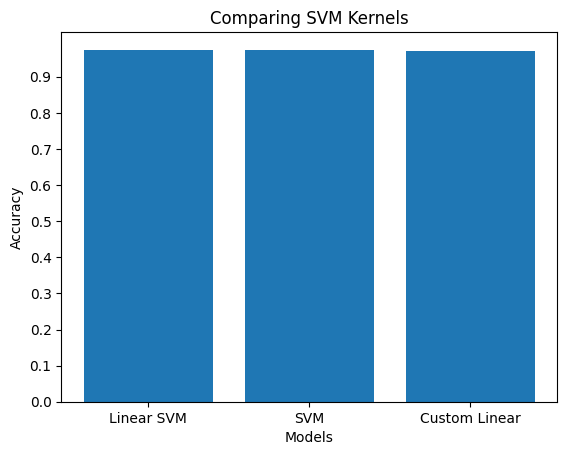

In [30]:
#Graph the comparison of the different models above based on accuracy
models = ['Linear SVM', 'SVM', "Custom Linear"]
accuracies = [linear_accuracy, nonlinear_accuracy, custom_linear_accuracy]
plt.bar(models, accuracies)
plt.title('Comparing SVM Kernels')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1, step=0.1))

Text(0, 0.5, 'Time to train in seconds')

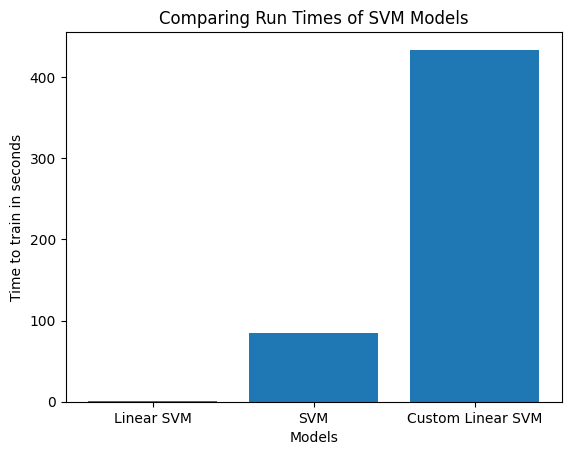

In [31]:
#Graph the comparison of the different models above based on time
models = ['Linear SVM', 'SVM', "Custom Linear SVM"]
run_times = [1.5854, 112.8304, 550.0572]
plt.bar(models, run_times)
plt.title('Comparing Run Times of SVM Models')
plt.xlabel('Models')
plt.ylabel('Time to train in seconds')

In [32]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 0.001,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
pred_counts = pd.Series(y_pred).value_counts()
print(pred_counts)

Personal Care    474
Accessories      403
Apparel          348
Footwear          91
Name: count, dtype: int64


In [34]:
zero_zero_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9642857142857143


In [35]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 0.01,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.01)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [36]:
zero_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9787234042553191


In [37]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 0.1,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
point_one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9802431610942249


In [39]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 1,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [40]:
one = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9749240121580547


In [41]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 3,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\costi\miniconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [42]:
three = accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

0.9749240121580547


(0.9, 1.0)

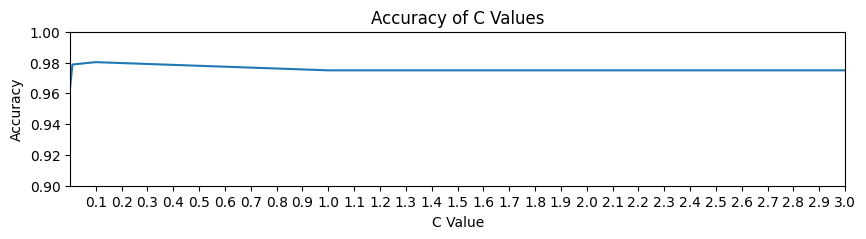

In [43]:
# Compare the accuracies of the models with different C values in a line graph
c_values = [0.001, 0.01, 0.1, 1, 3]
accuracies = [zero_zero_one, zero_one, point_one, one, three]
plt.figure(figsize=(10, 2))
plt.plot(c_values, accuracies)
plt.title('Accuracy of C Values')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 4, step=0.1)) 
plt.xlim(0.001, 3)
plt.ylim(0.9, 1)

In [22]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer, create a linear SCV model with a C value of 0.01,
# and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer()
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
#Visualize column indices to get a sense of the words present
vectorizer.vocabulary_

{'set': 7187,
 'of': 5786,
 'white': 8947,
 'socks': 7544,
 'with': 8988,
 'different': 2634,
 'coloured': 1760,
 'knitted': 4639,
 'patterns': 6074,
 'has': 4054,
 'an': 422,
 'elastane': 2956,
 'welt': 8926,
 'for': 3592,
 'firm': 3409,
 'no': 5602,
 'sag': 7013,
 'grip': 3951,
 'terry': 8186,
 'lining': 4862,
 'inside': 4443,
 'superior': 8008,
 'cushioning': 2204,
 'and': 430,
 'absorbency': 227,
 'above': 217,
 'ankle': 438,
 'length': 4775,
 'comfort': 1794,
 'toe': 8326,
 'lakmé': 4682,
 'absolute': 222,
 'forever': 3601,
 'silk': 7375,
 'eye': 3218,
 'liner': 4853,
 'is': 4526,
 'enriched': 3082,
 'vitamin': 8758,
 'to': 8321,
 'keep': 4612,
 'your': 9096,
 'lids': 4813,
 'soft': 7554,
 'smooth': 7508,
 'smudge': 7516,
 'proof': 6469,
 'offers': 5790,
 'velvety': 8690,
 'finish': 3390,
 'extreme': 3213,
 'men': 5196,
 'from': 3704,
 'slazenger': 7442,
 'perfect': 6127,
 'the': 8210,
 'dark': 2253,
 'mysterious': 5499,
 'debonair': 2291,
 'in': 4336,
 'youtones': 9101,
 'masculi

In [24]:
# Visualize accuracy
print(accuracy_score(y_test, y_pred))

0.9688449848024316


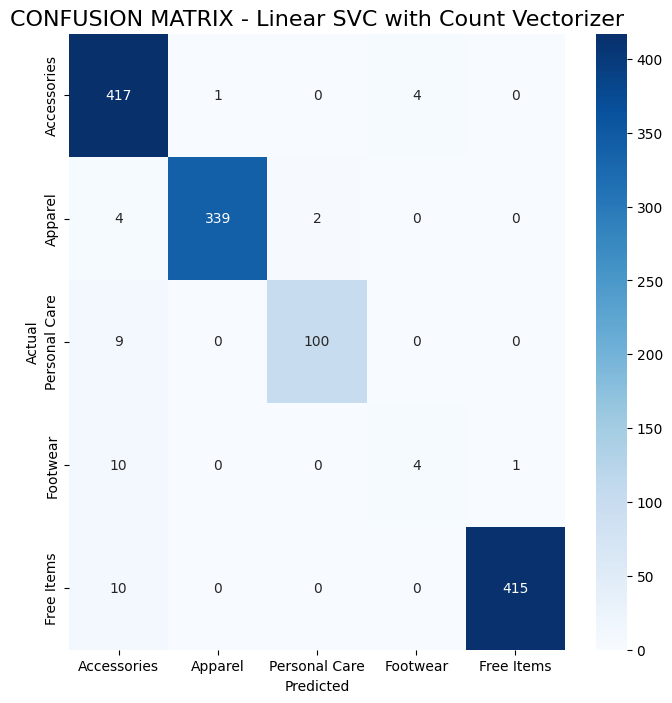

In [25]:
# Create a confusion matrix to see how many products the model classified correctly
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Count Vectorizer", size=16);

Different Text Classification Strategy
https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/

In [30]:
# Split the data into training and test, vectorize the data using a TF-IDF model, and 
# train a Linear SVC model using the vectorized data to find the accuracy
X_train, X_test, y_train, y_test = train_test_split(styles_df['description'], styles_df['masterCategory'], test_size=0.2, random_state = 42)
# Sublinear_tf finds the logarithm of term frequency to ensure the weight being assigned to terms is balanced
# min_df makes it so any terms that appear in less than 5 documents are ignored unser the assumption they are insignificant
# ngram_range makes it so both unigrams (single term) and bigrams (two terms) are considered
# Stop words removes common english words from consideration
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors_train = fitted_vectorizer.transform(X_train)
tfidf_vectorizer_vectors_test = fitted_vectorizer.transform(X_test)

model = LinearSVC().fit(tfidf_vectorizer_vectors_train, y_train)
y_pred = model.predict(tfidf_vectorizer_vectors_test)

In [31]:
# How much of each category was predicted
pred_counts = pd.Series(y_pred).value_counts()
print(pred_counts)

Accessories      436
Personal Care    410
Apparel          374
Footwear          95
Free Items         1
Name: count, dtype: int64


In [32]:
# Visualize accuracy
print(accuracy_score(y_test, y_pred))

0.9779635258358662


In [33]:
# Classification report for how well the TF-IDF Linear SVC model performed
print(classification_report(y_test, y_pred, target_names= styles_df['masterCategory'].unique()))

               precision    recall  f1-score   support

  Accessories       0.94      1.00      0.97       408
      Apparel       1.00      0.99      0.99       378
Personal Care       1.00      0.93      0.96       102
     Footwear       1.00      0.07      0.13        14
   Free Items       1.00      0.99      0.99       414

     accuracy                           0.98      1316
    macro avg       0.99      0.80      0.81      1316
 weighted avg       0.98      0.98      0.97      1316



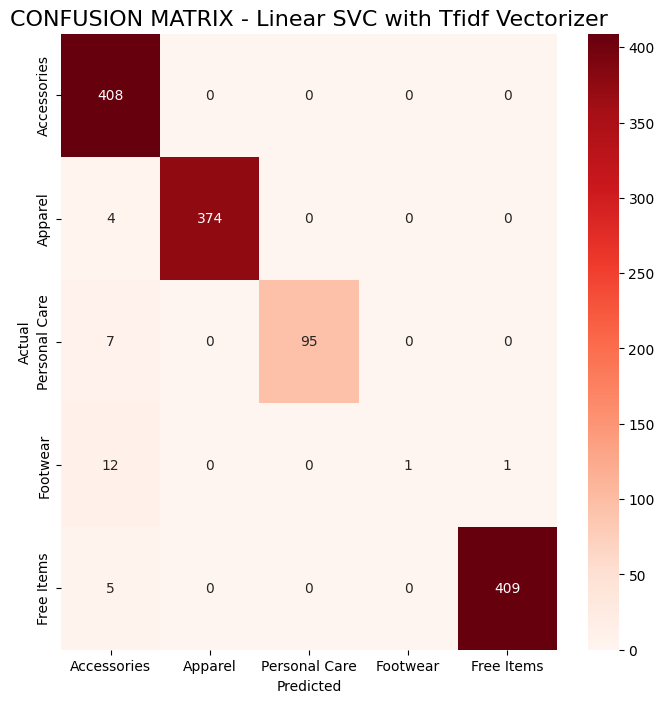

In [34]:
# Create a confusion matrix to see how many products the model classified correctly
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Reds", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Tfidf Vectorizer", size=16);

Count Vectorizer with Stop Words

In [37]:
# Split the data into train and test, vectorize it with a Bag of Words vectorizer that removes stop words, create a linear SCV model with a
# C value of 0.1, and find its accuracy
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(styles_df['description'], styles_df['masterCategory'], styles_df.index, test_size=0.2, random_state=1)
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = pd.DataFrame(vectorizer.fit_transform(X_train).toarray(), columns = vectorizer.get_feature_names_out())
X_test = pd.DataFrame(vectorizer.transform(X_test).toarray(), columns = vectorizer.get_feature_names_out())
model = LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

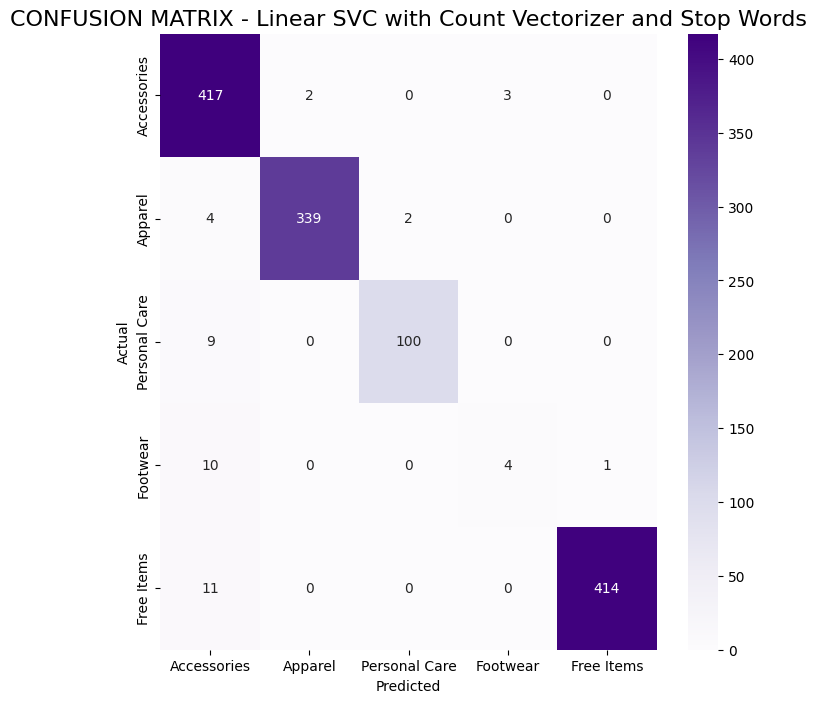

In [38]:
# Create a confusion matrix to see how many products the model classified correctly
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Purples", fmt='d',
            xticklabels=category_id_df.masterCategory.values, 
            yticklabels=category_id_df.masterCategory.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Linear SVC with Count Vectorizer and Stop Words", size=16);

In [39]:
#Visualize the accuracy of the model
print(accuracy_score(y_test, y_pred))

0.9680851063829787
